# Práctica 4: Entrenamiento de redes neuronales

In [97]:
# Library imports
import numpy as np
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import operator
from displayData import displayData
from checkNNGradients import *

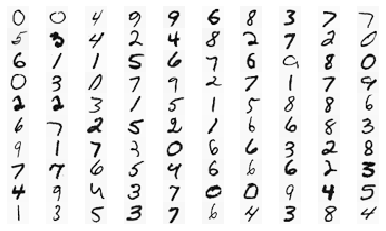

In [98]:
# Loading data
data = loadmat('ex4data1.mat')

y = data['y'].ravel()
X = data['X']
X_ones = np.hstack([np.ones([X.shape[0], 1]), X])

INIT_EPSILON = 0.12

# Loading weights
weights = loadmat('ex4weights.mat')
theta1_best, theta2_best = weights['Theta1'], weights['Theta2']

# Displaying data
sample = np.random.choice(X.shape[0], 100)
imgs = displayData(X[sample, :])

In [99]:
y=(y-1)
y_onehot=np.zeros((X.shape[0],10))#5000x10
for i in range(X.shape[0]):
    y_onehot[i][y[i]]=1

In [100]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def random_weights(L_in, L_out, epsilon = 0.0001):
    return np.random.random((L_in, L_out)) * (2 * epsilon) - epsilon

# Forward propagation
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]

    a1 = np.hstack([np.ones([m, 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

In [101]:
# Gradient function
def gradient(x, y, theta1,theta2, reg = 0):
    m = x.shape[0]
    
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)

    a1, z2, a2, z3, h = forward_propagate(x, theta1, theta2)

    
    #print("Theta1:{}".format(random_theta1.shape))
    #print("Theta2:{}".format(random_theta2.shape))
    
    for t in range(m):    
        a1t = a1[t, :] 
        #print("A1:{}".format(a1.shape))
        a2t = a2[t, :] 
        #print("A2:{}".format(a2.shape))
        ht = h[t, :]  
        #print("H:{}".format(ht.shape))
        yt = y[t]  
        #print("yt:{}".format(yt.shape))        
        d3t = ht - yt  
        #print("d3t:{}".format(d3t.shape))        
        d2t = np.dot(theta2.T, d3t) * (a2t * (1 - a2t)) 
        #print("d2t:{}".format(d2t.shape))
        delta1 = delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        delta1[1:, :] += (theta1[1:, :] * (reg / m))
        #print("delta1:{}".format(delta1.shape))
        delta2 = delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])
        delta2[1:, :] += (theta2[1:, :] * (reg / m))
        #print("delta2:{}".format(delta2.shape))
    
    return np.concatenate((np.ravel(delta1 / x.shape[0]) , np.ravel(delta2 / x.shape[0])))

In [102]:
def cost(X, y, theta1, theta2, num_etiquetas, reg=0):
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    m = X.shape[0]

    J = 0
    for i in range(m):
        J += np.sum(-y[i] * np.log(h[i]) - (1 - y[i]) * np.log(1 - h[i]))
    J = J / m

    sum_theta1 = np.sum(np.square(theta1[:, 1:]))
    sum_theta2 = np.sum(np.square(theta2[:, 1:]))

    term_3 = (sum_theta1 + sum_theta2) * (reg / (2 * m))

    return J + term_3


In [103]:
# Cost function
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    """ backprop devuelve el coste y el gradiente de una red neuronal de dos capas """
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))

    return cost(X, y, theta1, theta2, num_etiquetas, reg), gradient(X, y, theta1, theta2)

In [104]:
params_rn = np.concatenate((np.ravel(theta1_best), np.ravel(theta2_best)))
backprop(params_rn, 400, 25, 10, X, y_onehot, 1)[0]

0.38376985909092354

## Checkeo del gradiente

In [105]:
a = checkNNGradients(backprop, 1)

grad shape:  (38,)
num grad shape:  (38,)


AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 29 / 38 (76.3%)
Max absolute difference: 0.19999804
Max relative difference: 23.61214246
 x: array([ 0.0822085,  0.0015659,  0.009884 ,  0.0091147, -0.0804789,
        0.0193583, -0.0338319, -0.0559171, -0.1387866,  0.0274833,
       -0.0678184, -0.1007682, -0.0840919,  0.0065438, -0.0259151,...
 y: array([ 0.0822085,  0.1698601,  0.1917435,  0.0373387, -0.0804789,
       -0.1724266, -0.089715 ,  0.0754802, -0.1387866,  0.109907 ,
       -0.1766227, -0.3007662, -0.0840919,  0.0905772,  0.1722064,...

## Aprendizaje de los parámetros

In [106]:
fmin = opt.minimize(fun=backprop, x0=params_rn, args=(400, 25, 10, X, y_onehot, 1), method='TNC', jac=True, options={'maxiter': 70})

In [107]:
theta1_opt = np.reshape(fmin.x[:25 * (400 + 1)], (25, (400 + 1)))
theta2_opt = np.reshape(fmin.x[25 * (400 + 1):], (10, (25 + 1)))

In [108]:
results = forward_propagate(X, theta1_opt, theta2_opt)
m = X.shape[0]

def get_acurracy(Y, Y_pred):
    return np.sum((Y == np.array(Y_pred))) / m

def predict_nn(X, h):
    return [(np.argmax(h[image])) for image in range(X.shape[0])]

print("El porcentaje de acierto del modelo es: {}%".format(get_acurracy(y, predict_nn(X, results[4])) * 100))

El porcentaje de acierto del modelo es: 97.89999999999999%


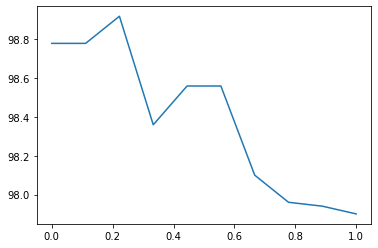

In [109]:
lambdas = np.linspace(0, 1, 10)
acurracy = []

for lbda in lambdas:
    fmin = opt.minimize(fun=backprop, x0=params_rn, args=(400, 25, 10, X, y_onehot, lbda), method='TNC', jac=True, options={'maxiter': 70})

    theta1_opt = np.reshape(fmin.x[:25 * (400 + 1)], (25, (400 + 1)))
    theta2_opt = np.reshape(fmin.x[25 * (400 + 1):], (10, (25 + 1)))

    results = forward_propagate(X, theta1_opt, theta2_opt)
    acurracy.append(get_acurracy(y, predict_nn(X, results[4])) * 100)

plt.plot(lambdas, acurracy)
plt.show()

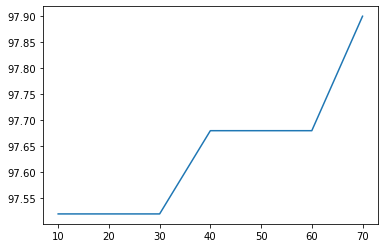

In [111]:
iterations = np.linspace(10, 70, 7)
acurracy = []

for iteration in iterations:
    fmin = opt.minimize(fun=backprop, x0=params_rn, args=(400, 25, 10, X, y_onehot, 1), method='TNC', jac=True, options={'maxiter': int(iteration)})

    theta1_opt = np.reshape(fmin.x[:25 * (400 + 1)], (25, (400 + 1)))
    theta2_opt = np.reshape(fmin.x[25 * (400 + 1):], (10, (25 + 1)))

    results = forward_propagate(X, theta1_opt, theta2_opt)
    acurracy.append(get_acurracy(y, predict_nn(X, results[4])) * 100)

plt.plot(iterations, acurracy)
plt.show()